# Understanding the Non-Uniform Fast Fourier Transform (NUFFT)

MATH7001: Advanced Mathematical Investigations

Kyra Lee


# Motivation:
 - Problem: Reconstruct a signal from nonuniform frequency samples
 - Standard FFT only works for uniform sampling

 - NUFFT enables fast transforms for nonuniform data, which is critical for real-world, irregularly sampled signals 
 

# Applications


 

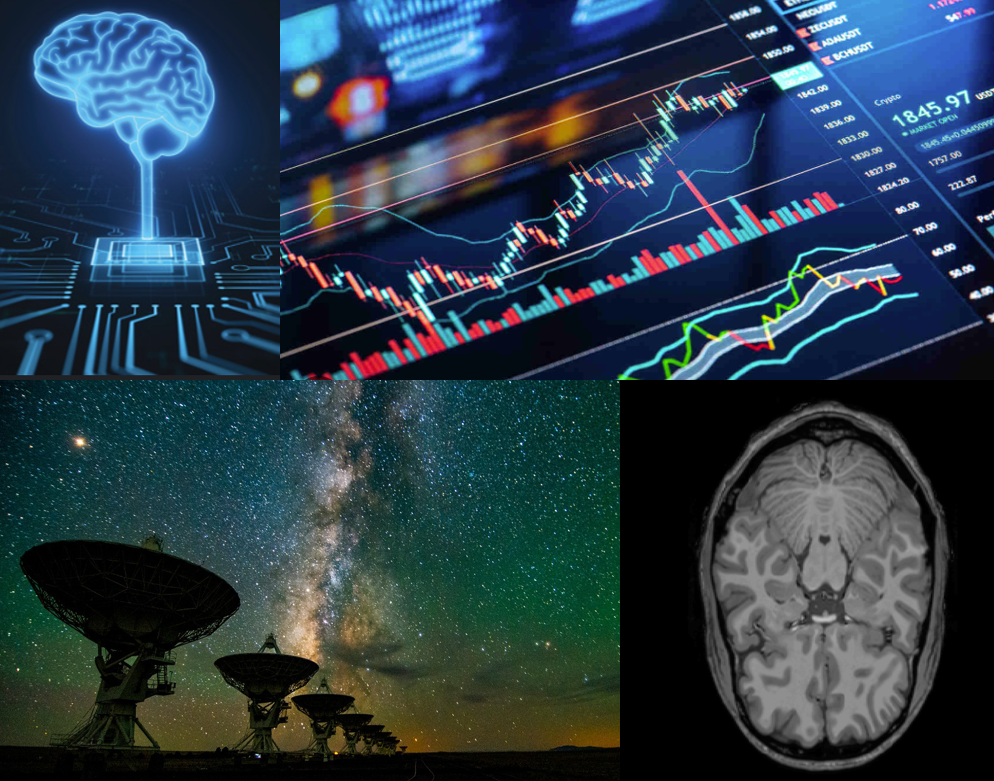

# Literature Review Takeaways
- Many are working to optimize the NUFFT itself
- No known research has implemented the NUFFT for processing neuromorphic data

- Rather than being contradictory to existing techniques, the NUFFT can be seen as a complementary approach that enhances their capabilities


# NUFFT Overview  
1. NUFFT takes data at unevenly spaced points.

2. It uses a special "kernel function" to "spread" each data point onto a regular, evenly spaced grid.

3. Then it applies a regular FFT to this grid.

4. Finally, it does some correction (scaling/deconvolution) to get the final result.



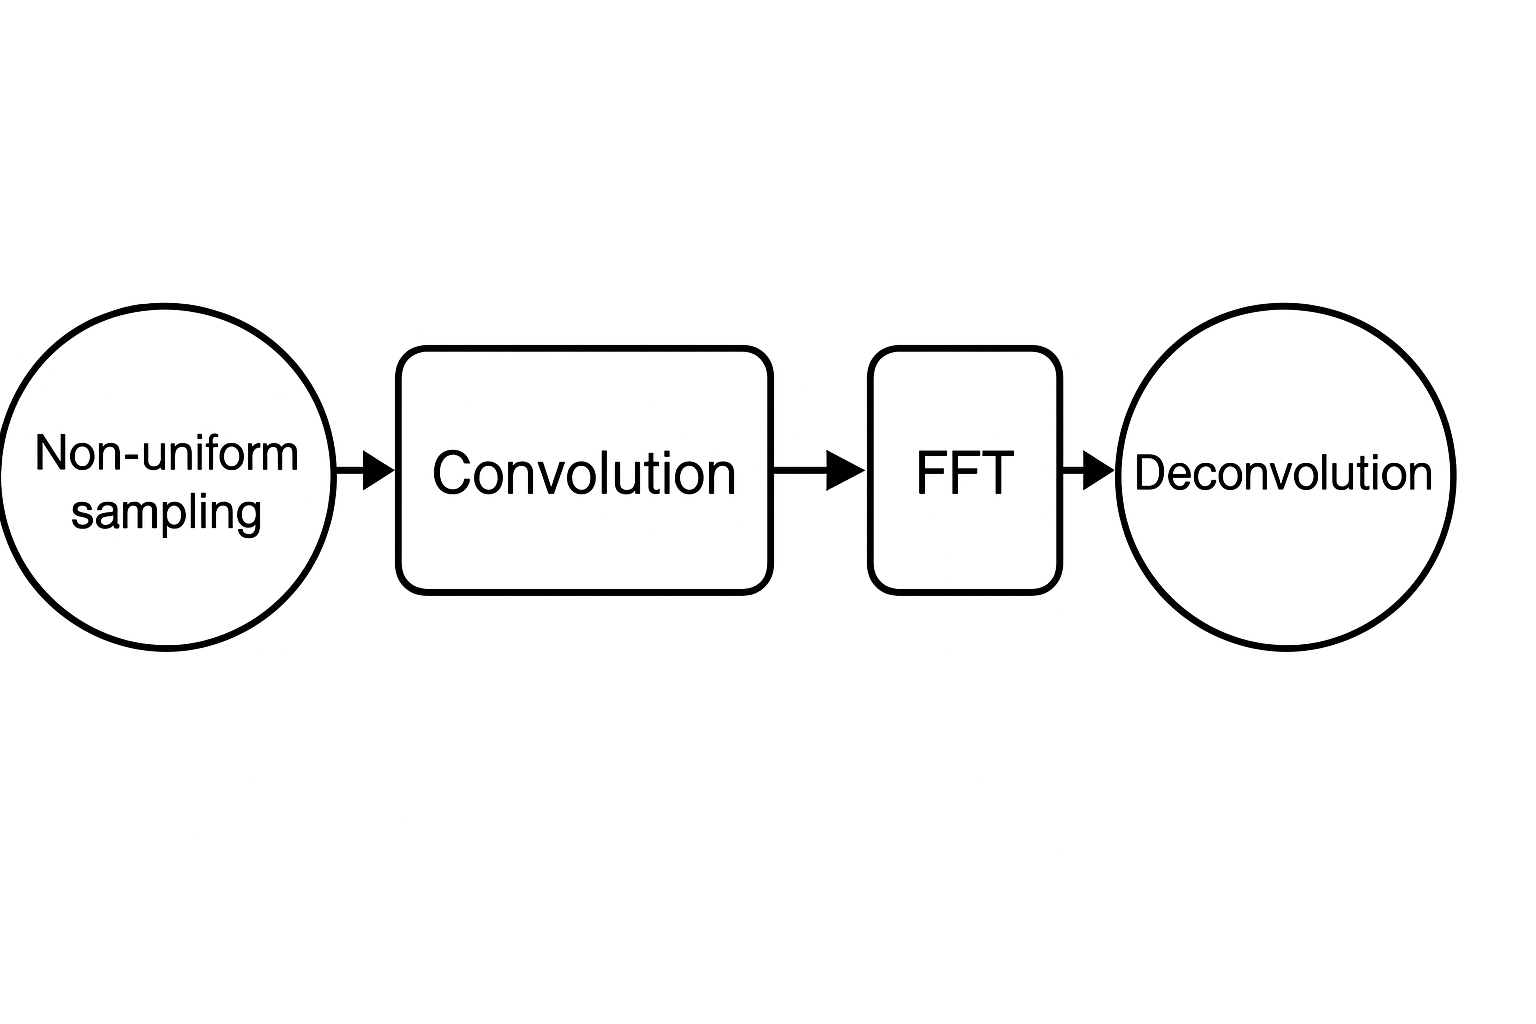

# Discrete Fourier Transform (DFT)
Given $ N $ uniformly spaced time samples $ f_j $ at positions $ x_j = \frac{2\pi j}{N} $, the DFT is given by:
$$
\hat{f}_k = \sum_{j=0}^{N-1} f_j \, e^{-i k x_j}, \quad k = 0, 1, \dots, N-1
$$

Its computational complexity is $\textit{O} (N^2) $ which becomes impractical for large datasets. 

# Non-Uniform DFT
The nonuniform discrete Fourier transform (NUDFT) generalizes the DFT to handle cases where the time samples are not uniformly spaced. Let $ p_0, \dots, p_{N-1} \in [0,1] $ represent the sample locations (which may be non-uniform) and $ f_0, \dots, f_{N-1} \in [0, N] $ represent the corresponding frequencies. The nonuniform DFT is then:

$$
X_k = \sum_{n=0}^{N-1} x_n e^{-2\pi i p_n f_k}, \quad 0 \leq k \leq N-1
$$

Note that if $ p_n = \frac{n}{N} $ and $ f_k = k $, this equation reduces to the standard DFT.


# Non-Uniform Fast Fourier Transform (NUFFT)

The NUFFT extends the DFT to handle non-uniform sampling in an efficient manner. In the case of the Type 1 NUFFT, we are given $ M $ data points $ f_j $ sampled at nonuniform locations $ x_j \in [-\pi, \pi] $, and we wish to compute a uniform set of frequency coefficients $ \hat{f}_k $ for $ k = -K, \dots, K $.

The NUFFT formula is:

$$
\hat{f}_k = \sum_{j=0}^{M-1} f_j \, e^{-i k x_j}, \quad k = -K, \dots, K
$$

This formula is mathematically identical to the DFT but applied to non-uniform sample points $ x_j $. The NUFFT allows us to efficiently compute a Fourier transform for data that is sampled at irregular intervals, avoiding the need for costly interpolation methods.



# FINUFFT 

Library for computing nonuniform fast Fourier transforms (NUFFTs), written in C++ with interfaces for Python, MATLAB, and Fortran and has order $ \textit{O} (N $ log $ N + M)$. 

Types supported:

Type 1: From nonuniform points → uniform frequency grid

Type 2: From uniform frequency grid → nonuniform points

Type 3: Fully nonuniform (both input and output points are nonuniform)

The Non-Uniform Fast Fourier Transform package, FINUFFT, relies on several conditions and assumptions:
1. Default kernel: "exponential of semi-circle"  $$\phi(z) = e^{\beta \sqrt{1 - z^2}} \mathrm{\,for\,} z \in [-1,1],  0 \mathrm{\, otherwise} $$ because this kernel has been proven to result in an error that decreases exponentially. 

2. Deconvolution: diagonal scaling in frequency space
    - Each nonuniform point $x_j$ is spread to a nearby set of uniform grid points using a kernel $\phi$. This spreading is equivalent to a convolution of the original signal $f(x)$ with the kernel $\phi(x)$: $$ f_{\text{grid}}(x) = (f * \phi)(x) $$
    - When we apply the FFT to this convolved signal, we are computing the Fourier transform of the blurred data. By the Convolution Theorem, convolution in time corresponds to multiplication in frequency so: $$ \widehat{f_{\text{grid}}}(k) = \hat{f}_k \cdot \hat{\phi}_k $$
    - To recover the original frequency coefficients $\hat{f}_k$, we must undo the convolution by dividing by the Fourier transform of the kernel: $$ \hat{f}_k = \frac{\widehat{f_{\text{grid}}}(k)}{\hat{\phi}_k} $$
    - In practice, this deconvolution is implemented as a diagonal scaling in the frequency domain. Let $\mathbf{\hat{f}}$ be the vector of Fourier coefficients and let $\mathbf{D}$ be a diagonal matrix where:$$ D_{kk} = \hat{\phi}_k $$
    - Then, $$ \mathbf{\hat{f}} = \mathbf{D}^{-1} \cdot \widehat{f_{\text{grid}}} $$
    - This is diagonal scaling because we are multiplying the vector by a diagonal matrix (or equivalently, dividing each component by $\hat{\phi}_k$).


Before simulating neuromorphic data, we will compare the FINUFFT package against the standard FFT on a simple sinusoidal wave.

# Signal Generation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import finufft
from scipy.fft import fft, fftfreq, ifft
from scipy.interpolate import interp1d

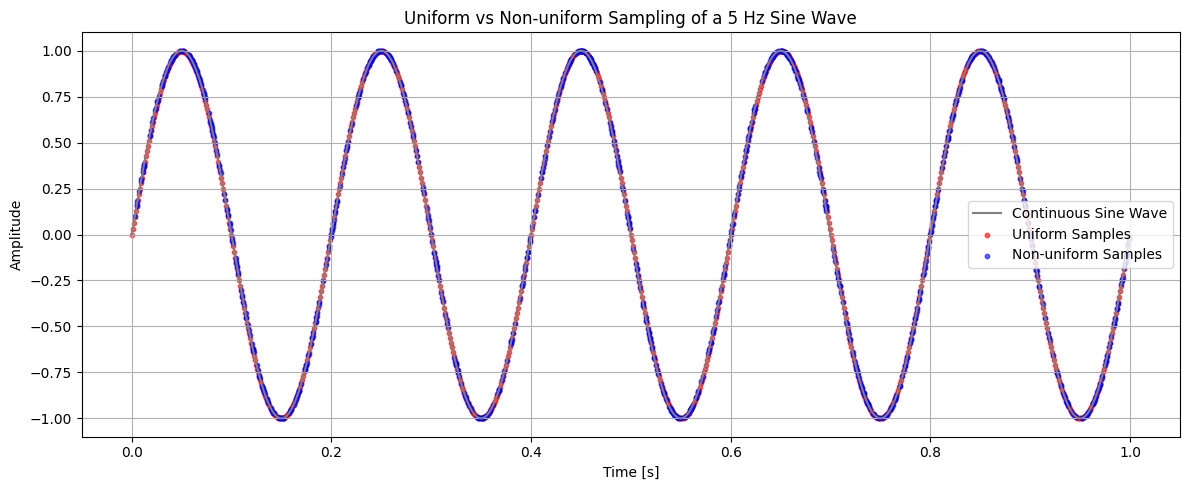

In [ ]:
# Parameters
frequency = 5  # Hz (signal frequency)
duration = 1  # second (signal duration)
N = 1000       # Number of samples

# Uniform sine wave generator
def uniform_sine_wave(frequency, duration, N):
    t = np.linspace(0, duration, N, endpoint=False)
    y = np.sin(2 * np.pi * frequency * t)
    return t, y.astype(np.complex128)

# Non-uniform sine wave generator
def NU_sine_wave(frequency, duration, N):
    t = np.sort(np.random.uniform(0, duration, N))
    y = np.sin(2 * np.pi * frequency * t)
    return t, y.astype(np.complex128)

# Generate both types of signals
t_uniform, y_uniform = uniform_sine_wave(frequency, duration, N)
t_nu, y_nu = NU_sine_wave(frequency, duration, N)

# Plot
plt.figure(figsize=(12, 5))

# Continuous background sine wave for reference
t_cont = np.linspace(0, duration, 5000)
y_cont = np.sin(2 * np.pi * frequency * t_cont)
plt.plot(t_cont, y_cont, color='gray', label='Continuous Sine Wave', linewidth=1.5)

# Uniform samples
plt.scatter(t_uniform, y_uniform.real, color='red', s=10, label='Uniform Samples', alpha=0.6)

# Non-uniform samples
plt.scatter(t_nu, y_nu.real, color='blue', s=10, label='Non-uniform Samples', alpha=0.6)

plt.title("Uniform vs Non-uniform Sampling of a 5 Hz Sine Wave")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# FFT vs NUFFT (uniform sampling)

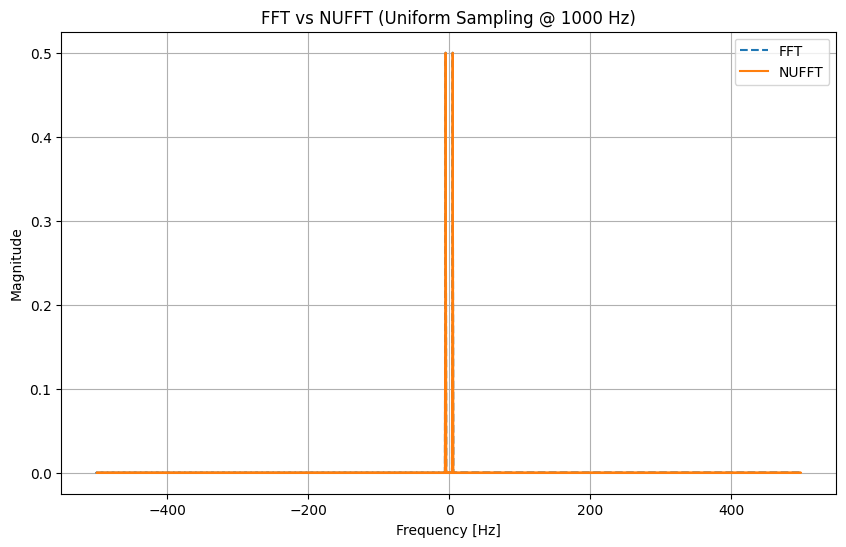

In [ ]:
def compare_fft_nufft_uniform(frequency=5, duration=1, sampling_rate=1000):
    N = sampling_rate
    t, y = uniform_sine_wave(frequency, duration, N)

    fft_values = fft(y)
    fft_freqs = fftfreq(N, 1 / sampling_rate)

    omega = 2 * np.pi * (t / duration - 0.5)
    nufft_result = finufft.nufft1d1(omega, y, N, isign=-1)
    nufft_result = np.fft.fftshift(nufft_result)

    nufft_freqs = (np.fft.fftshift(np.arange(N)) - N // 2) * (sampling_rate / N)

    plt.figure(figsize=(10, 6))
    plt.plot(fft_freqs, np.abs(fft_values)/N, label='FFT', linestyle='dashed')
    plt.plot(nufft_freqs, np.abs(nufft_result)/N, label='NUFFT', linestyle='solid')
    plt.title(f"FFT vs NUFFT (Uniform Sampling @ {sampling_rate} Hz)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.legend()
    plt.show()

compare_fft_nufft_uniform()

Observe that if data is sampled uniformly, the NUFFT and the FFT perform very similarly. Note that even though the NUFFT was designed for non-uniform sampling, it still performs well on uniform data. Why?

1. The NUFFT is a generalization of the FFT. It can handle any arbitrary set of time or frequency points, including regularly spaced ones. So when you give it uniform input, you're essentially using a more flexible version of the FFT — and in that special case, the NUFFT behaves like the FFT.

2. The underlying math doesn't break down just because the data is uniform. NUFFT uses interpolation and kernel-based gridding techniques which still approximate the Fourier integral correctly even when the samples are equally spaced. The only difference is that in this case, the approximation is not necessary — but it still works.

However, the trade off is usually speed. Even though the NUFFT gives accurate results for uniform data, the FFT is typically faster in this case. 

# FFT vs NUFFT (non-uniform sampling)

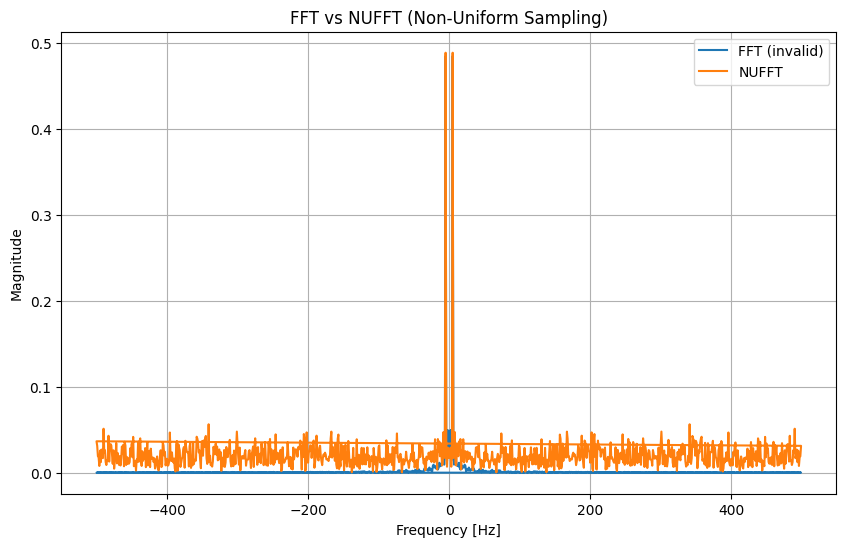

In [ ]:
def compare_fft_nufft_nonuniform(frequency=5, duration=1, N=1000):
    t, y = NU_sine_wave(frequency, duration, N)

    # FFT fails on non-uniform samples
    try:
        fft_values = fft(y)
        fft_freqs = fftfreq(N, duration/N)
    except Exception as e:
        fft_values = None

    omega = 2 * np.pi * (t / duration - 0.5)
    nufft_result = finufft.nufft1d1(omega, y, N, isign=-1)
    nufft_result = np.fft.fftshift(nufft_result)
    nufft_freqs = (np.fft.fftshift(np.arange(N)) - N // 2) * (1 / duration)

    plt.figure(figsize=(10, 6))
    if fft_values is not None:
        plt.plot(fft_freqs, np.abs(fft_values)/N, label='FFT (invalid)', linestyle='solid')
    plt.plot(nufft_freqs, np.abs(nufft_result)/N, label='NUFFT', linestyle='solid')
    plt.title("FFT vs NUFFT (Non-Uniform Sampling)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.legend()
    plt.show()

compare_fft_nufft_nonuniform()

If the samples are instead located at irregular/non-uniform time points, then the FFT is no longer valid because:

- The DFT matrix is no longer orthogonal.

- The frequency-domain assumptions (like harmonics being evenly spaced) no longer hold.

- The result of applying FFT to non-uniform data is typically nonsense — you’ll get spectral leakage, distortion, or misleading frequencies.

Observe that there are the little wiggles on either side of the dominant peaks. Even if the sine wave is clean, sampling it over a finite time window is equivalent to multiplying by a window in the time domain. In the frequency domain, this multiplication becomes a convolution, and for sharp windows (like rectangular ones), the convolution spreads energy into neighboring frequencies. The main peak is centered correctly at the expected frequency, and the magnitude is close to expected, indicating the NUFFT has likely captured the dominant spectral content accurately, and the small wiggles are not necessaily a failure of the algorithm. 

We can also perform the inverse FFT and the inverse NUFFT to compare. 

# IFFT vs INUFFT (uniform sampling)

c:\Users\kyral\.vscode\NUFFT Work\.venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\kyral\.vscode\NUFFT Work\.venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


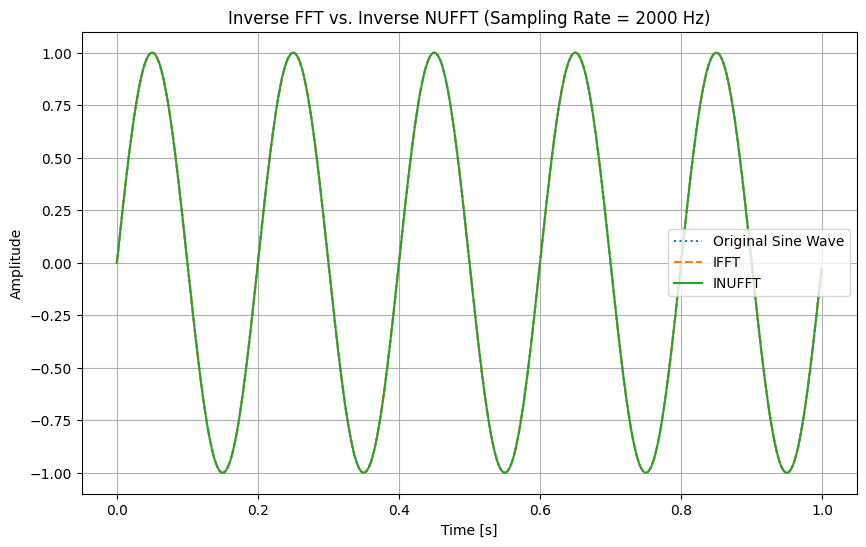

In [ ]:
def plot_inverse_fft_nufft(sampling_rate, N):
    # Generate sine wave
    t, y = uniform_sine_wave(frequency, duration, N)

    # Compute FFT
    fft_values = fft(y)

    # Compute NUFFT (Type-1)
    omega = 2 * np.pi * (t / duration - 0.5)  # Map t to [-pi, pi]
    nufft_result = finufft.nufft1d1(omega, y, N, isign=-1)

    # Inverse FFT (IFFT) - Correct scaling: divide by N for proper reconstruction
    ifft_result = ifft(fft_values) * N

    # Inverse NUFFT (INUFFT) - Mapping back to non-uniform time domain
    inufft_result = finufft.nufft1d1(omega, nufft_result, N, isign=1)

    # Normalize to avoid over-scaling
    ifft_result /= N
    inufft_result /= N

    # Plot original sine wave, IFFT, and INUFFT results
    plt.figure(figsize=(10, 6))
    plt.plot(t, y, label="Original Sine Wave", linestyle="dotted")
    plt.plot(t, np.real(ifft_result), label="IFFT", linestyle="dashed")
    plt.plot(t, np.real(inufft_result), label="INUFFT", linestyle="solid")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.title(f"Inverse FFT vs. Inverse NUFFT (Sampling Rate = {sampling_rate} Hz)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Parameters
sampling_rate = 2000
N = 1000
frequency = 5  # Define frequency of the sine wave (in Hz)
duration = 1  # Duration in seconds

# Call the inverse FFT/NUFFT plotting function
plot_inverse_fft_nufft(sampling_rate, N)


As expected, the IFFT and INUFFT both reconstruct the original sine wave successfully. 

# IFFT vs INUFFT (non-uniform sampling)

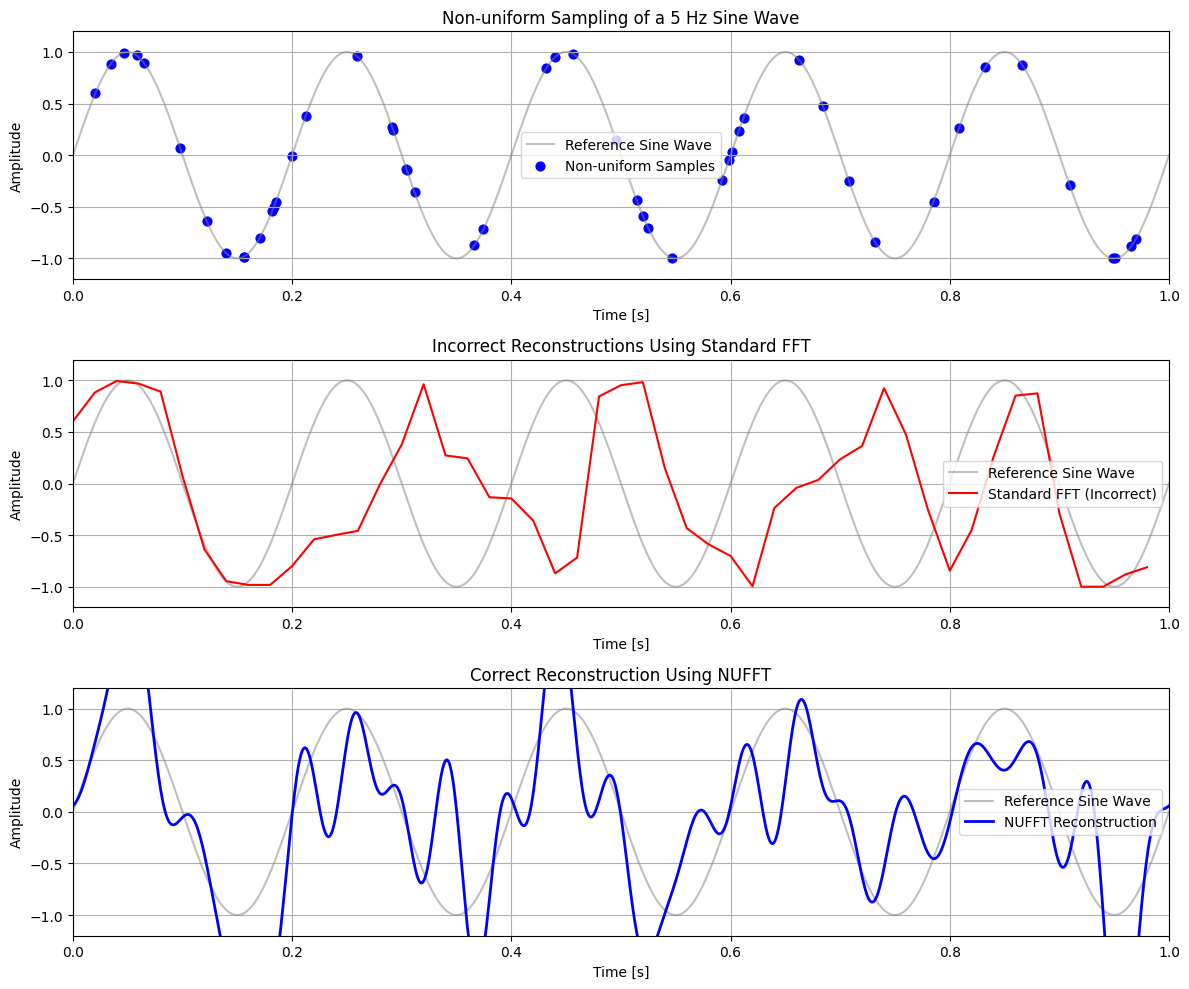

In [ ]:
def compare_reconstruction_methods():
    # Parameters
    frequency = 5  # Hz (signal frequency)
    duration = 1.0  # second (signal duration)
    N = 50  # Number of samples
    
    # Generate reference high-resolution sine wave
    t_ref = np.linspace(0, duration, 1000)
    y_ref = np.sin(2 * np.pi * frequency * t_ref)
    
    # Generate non-uniform samples
    t_nu, y_nu = NU_sine_wave(frequency, duration, N)
    
    # Create uniform time grid for interpolation comparison
    t_uniform = np.linspace(0, duration, N, endpoint=False)
    
    # Standard FFT approach (incorrect for non-uniform data)
    fft_result = np.fft.fft(y_nu)
    ifft_result = np.fft.ifft(fft_result)
    
    # Interpolation approach (linear interpolation onto uniform grid)
    interp_func = interp1d(t_nu, y_nu, kind='linear', bounds_error=False, fill_value=0)
    y_interp = interp_func(t_uniform)
    fft_interp = np.fft.fft(y_interp)
    ifft_interp = np.fft.ifft(fft_interp)
    
    # NUFFT
    
    # Step 1: Normalize time points to [-π, π] (FINUFFT expects points in [-π, π] range)
    t_nu_scaled = (t_nu / duration) * 2 * np.pi - np.pi
    t_recon = np.linspace(0, duration, 1000)
    t_recon_scaled = (t_recon / duration) * 2 * np.pi - np.pi

    # Step 2: Forward NUFFT (non-uniform time -> uniform frequency)
    fhat = finufft.nufft1d1(t_nu_scaled, y_nu.astype(np.complex128), N, eps=1e-12)

    # Step 3: Inverse NUFFT (uniform frequency -> fine non-uniform time points)
    y_recon = finufft.nufft1d2(t_recon_scaled, fhat, eps=1e-12) / N  # Don't forget scaling by N!

    
    # Plotting
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Non-uniform sampling
    plt.subplot(3, 1, 1)
    plt.plot(t_ref, y_ref, 'gray', label='Reference Sine Wave', alpha=0.5)
    plt.scatter(t_nu, y_nu, color='blue', s=40, label='Non-uniform Samples')
    plt.title("Non-uniform Sampling of a 5 Hz Sine Wave")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, duration)
    plt.ylim(-1.2, 1.2)
    
    # Plot 2: Incorrect reconstructions (standard FFT and interpolation)
    plt.subplot(3, 1, 2)
    plt.plot(t_ref, y_ref, 'gray', label='Reference Sine Wave', alpha=0.5)
    plt.plot(t_uniform, ifft_result.real, 'r-', label='Standard FFT (Incorrect)')
    plt.title("Incorrect Reconstructions Using Standard FFT")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, duration)
    plt.ylim(-1.2, 1.2)
    
    # Plot 3: NUFFT reconstruction
    plt.subplot(3, 1, 3)
    plt.plot(t_ref, y_ref, 'gray', label='Reference Sine Wave', alpha=0.5)
    plt.plot(t_recon, y_recon.real, 'b-', label='NUFFT Reconstruction', linewidth=2)
    plt.title("Correct Reconstruction Using NUFFT")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.xlim(0, duration)
    plt.ylim(-1.2, 1.2)
    
    plt.tight_layout()
    plt.show()


compare_reconstruction_methods()


A standard FFT assumes uniform sampling, and applying it to nonuniform data results in incorrect spectral and time-domain reconstructions.

A NUFFT handles nonuniformly sampled data properly, respecting the nonuniform sample locations.

However, nonuniform sampling itself can lead to reconstruction artifacts (e.g., oscillations, aliasing), especially when samples are clustered or uneven.

Increasing the number of samples improves reconstruction only if the sampling covers the signal well and fairly uniformly.

✅ So the NUFFT correctly solves the problem at the Fourier transform level.
🚫 But NUFFT cannot fix bad or irregular sampling patterns.

# NUFFT for Neuromorphic Spike Signals
Neuromorphic signals often consist of **spike events** rather than smooth, continuous waveforms. These are inherently **non-uniform** in time.
Let's generate a synthetic spike train and analyze how the NUFFT handles such data.

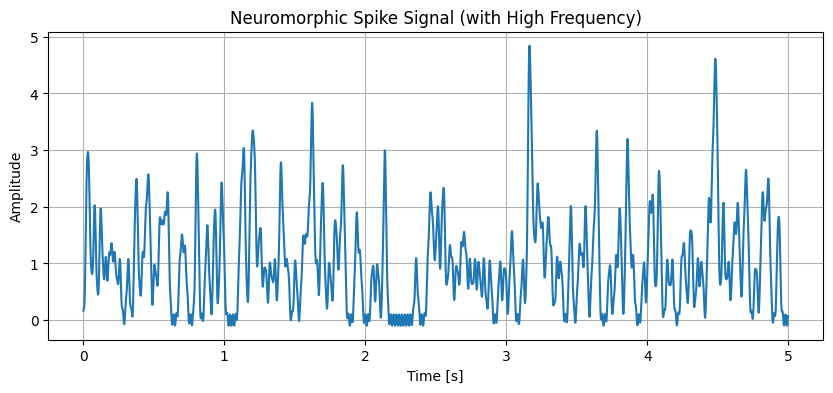

In [ ]:
def generate_spike_train(duration=5.0, N=1000, spike_count=500, decay=0.01, high_freq=True):
    # Non-uniform spike times (random placement)
    times = np.sort(np.random.uniform(0, duration, spike_count))
    
    # Signal time grid
    signal_time = np.linspace(0, duration, N, endpoint=False)
    signal = np.zeros_like(signal_time)
    
    # Adding spikes to the signal with a Gaussian decay
    for spike_time in times:
        spike = np.exp(-(signal_time - spike_time)**2 / (2 * decay**2))
        signal += spike
    
    # Add high-frequency oscillations to the signal
    if high_freq:
        # Adding a high-frequency component (e.g., 50 Hz)
        freq = 50  # High frequency component to make signal more complex
        signal += 0.1 * np.cos(2 * np.pi * freq * signal_time)
    
    return signal_time, signal.astype(np.complex128), times

# Generate a high-resolution reference signal once
duration = 5.0
N_ref = 2000  # High resolution reference
spike_count = 200
t_ref, y_ref, spike_times = generate_spike_train(duration, N_ref, spike_count)

# Plot the original signal with sparse spikes and high-frequency component
plt.figure(figsize=(10, 4))
plt.plot(t_ref, y_ref.real)
plt.title("Neuromorphic Spike Signal (with High Frequency)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


The plot shows the real part of the resulting synthetic neuromorphic signal, which is the sum of all Gaussian-shaped spikes. Each spike decays over time, and their superposition results in a smooth but jagged signal resembling neuromorphic data.


# NUFFT for Various Sampling Rates

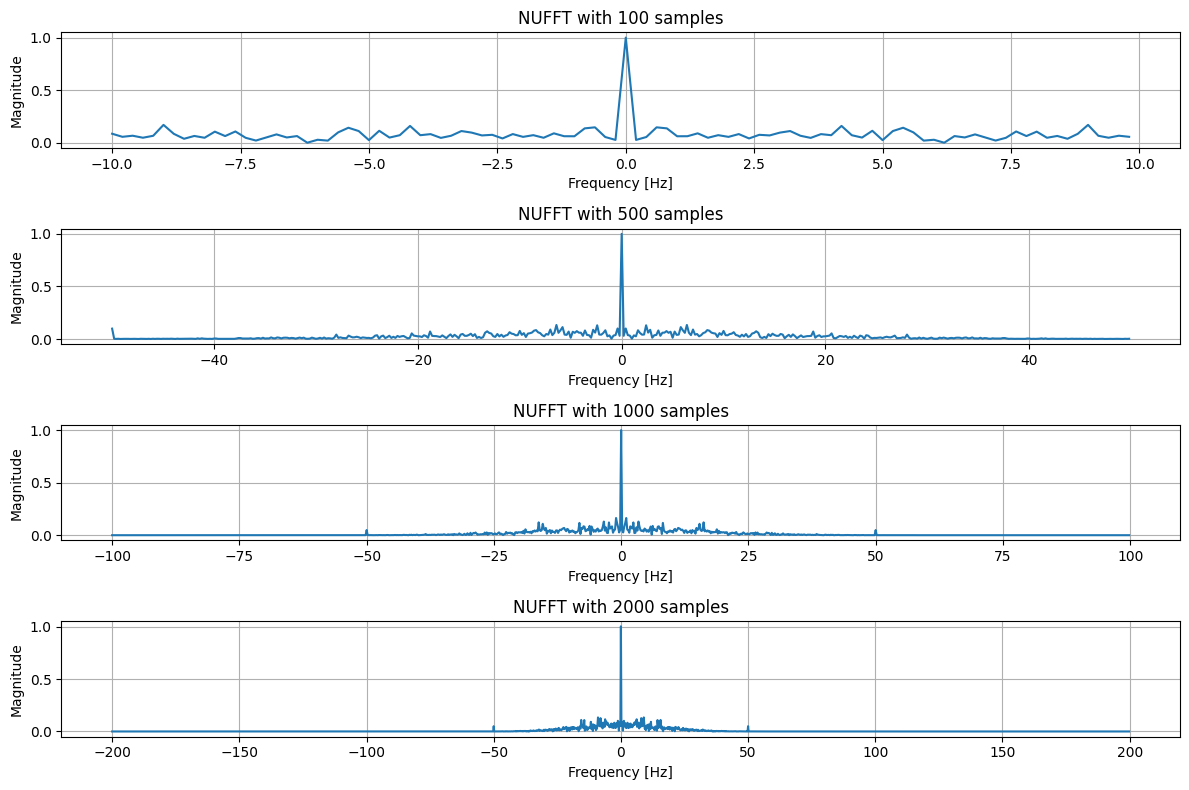

In [ ]:
# Function to perform NUFFT for various sample rates and plot them separately
def compare_nufft_sample_rates(duration=5.0, spike_count=200, N_list=[100, 500, 1000, 2000], high_freq=True):
    fig, axes = plt.subplots(len(N_list), 1, figsize=(12, 8))
    
    for idx, N in enumerate(N_list):
        # Generate the neuromorphic signal with fixed spike count and varying number of sample points
        t_spike, y_spike, spike_times = generate_spike_train(duration, N, spike_count, high_freq=high_freq)
        
        # Compute omega for the NUFFT (non-uniform frequencies)
        omega_spike = 2 * np.pi * (t_spike / duration - 0.5)

        # NUFFT Analysis (using non-uniform sampling)
        nufft_vals = finufft.nufft1d1(omega_spike, y_spike, N, isign=-1)

        # Frequency bins for visualization (corresponding to NUFFT)
        nufft_freqs = np.fft.fftfreq(N, d=duration / N)
        nufft_freqs = np.fft.fftshift(nufft_freqs)  # Shift frequencies to center around zero
        
        # Plot NUFFT results for each number of sample points on a separate subplot
        axes[idx].plot(nufft_freqs, np.abs(nufft_vals)/N)
        axes[idx].set_title(f"NUFFT with {N} samples")
        axes[idx].set_xlabel("Frequency [Hz]")
        axes[idx].set_ylabel("Magnitude")
        axes[idx].grid(True)
    
    plt.tight_layout()
    plt.show()


compare_nufft_sample_rates(duration=5.0, spike_count=200, N_list=[100, 500, 1000, 2000], high_freq=True)

As N increases:

- The signal is sampled more densely in time, leading to higher frequency resolution.

- The NUFFT output becomes smoother and more continuous, with fewer artifacts or "wiggles" because the signal's frequency components are represented more accurately.

# Inverse NUFFT for Neuromorphic Data

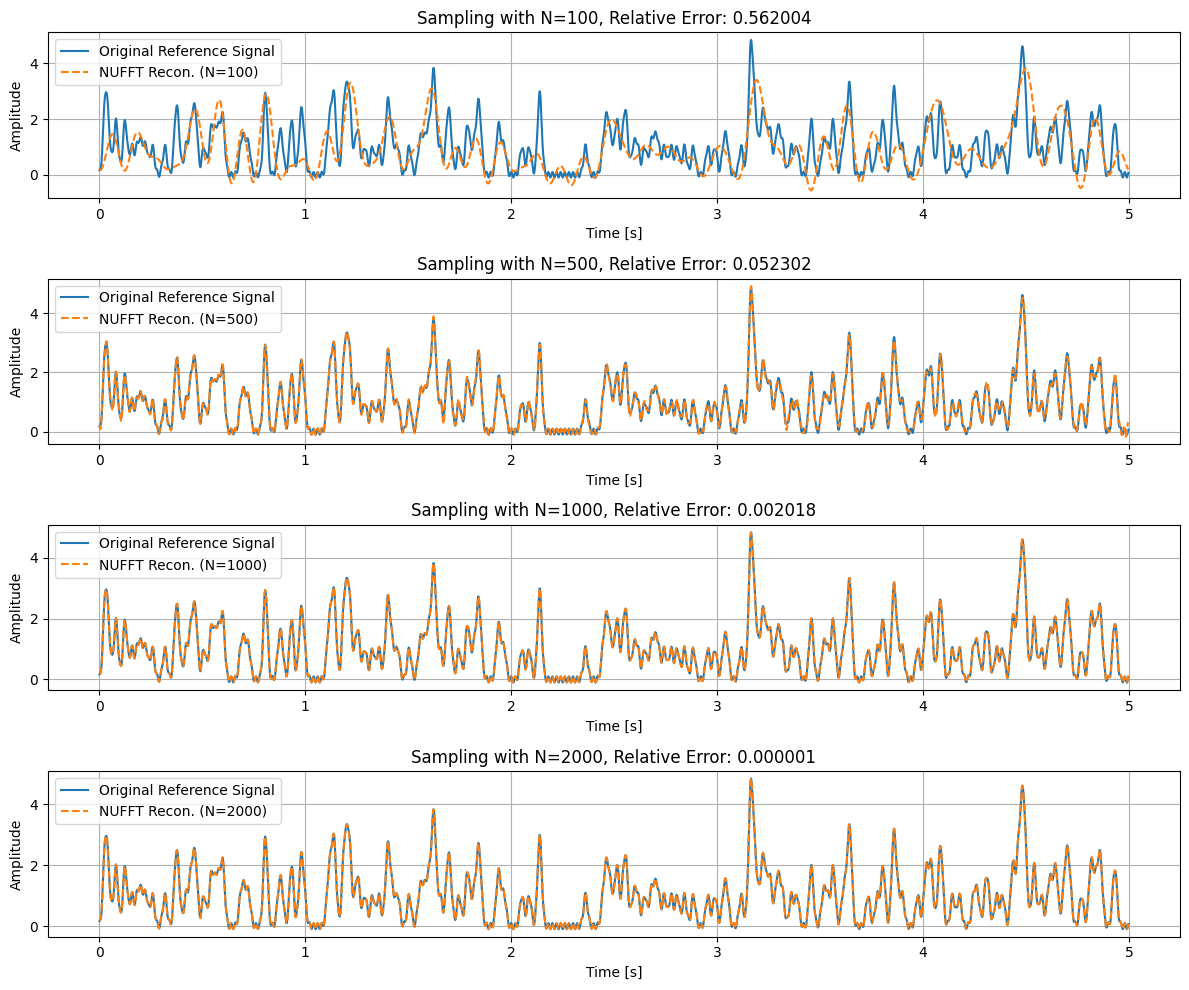

In [ ]:
# Create a figure with subplots for different sample counts
N_list = [100, 500, 1000, 2000]
fig, axes = plt.subplots(len(N_list), 1, figsize=(12, 10))

# Plot the original reference signal on all subplots for comparison
for idx, N in enumerate(N_list):
    # Sample the reference signal at N points (simulating different sampling rates)
    sample_indices = np.linspace(0, len(t_ref)-1, N, dtype=int)
    t_sample = t_ref[sample_indices]
    y_sample = y_ref[sample_indices]
    
    # Normalize times to [-π, π] for NUFFT
    omega_sample = 2 * np.pi * (t_sample / duration - 0.5)
    
    # Forward NUFFT: nonuniform time → uniform frequency
    nufft_vals = finufft.nufft1d1(omega_sample, y_sample, N, isign=-1)
    
    # Compute inverse NUFFT back to the original reference time points
    omega_ref = 2 * np.pi * (t_ref / duration - 0.5)
    nufft_reconstructed = finufft.nufft1d2(omega_ref, nufft_vals, isign=1) / N
    
    # Calculate reconstruction error
    error = np.linalg.norm(y_ref.real - nufft_reconstructed.real) / np.linalg.norm(y_ref.real)
    
    # Plot both signals
    axes[idx].plot(t_ref, y_ref.real, '-', label="Original Reference Signal")
    axes[idx].plot(t_ref, nufft_reconstructed.real, '--', label=f"NUFFT Recon. (N={N})")
    axes[idx].set_title(f"Sampling with N={N}, Relative Error: {error:.6f}")
    axes[idx].set_xlabel("Time [s]")
    axes[idx].set_ylabel("Amplitude")
    axes[idx].legend()
    axes[idx].grid(True)

plt.tight_layout()
plt.show()

# Mean Square Error for NUFFT

Completed N=50, MSE=0.744151
Completed N=75, MSE=0.657701
Completed N=100, MSE=0.458735
Completed N=150, MSE=0.288951
Completed N=200, MSE=0.120230
Completed N=500, MSE=0.005531
Completed N=1000, MSE=0.001352
Completed N=2000, MSE=0.000000


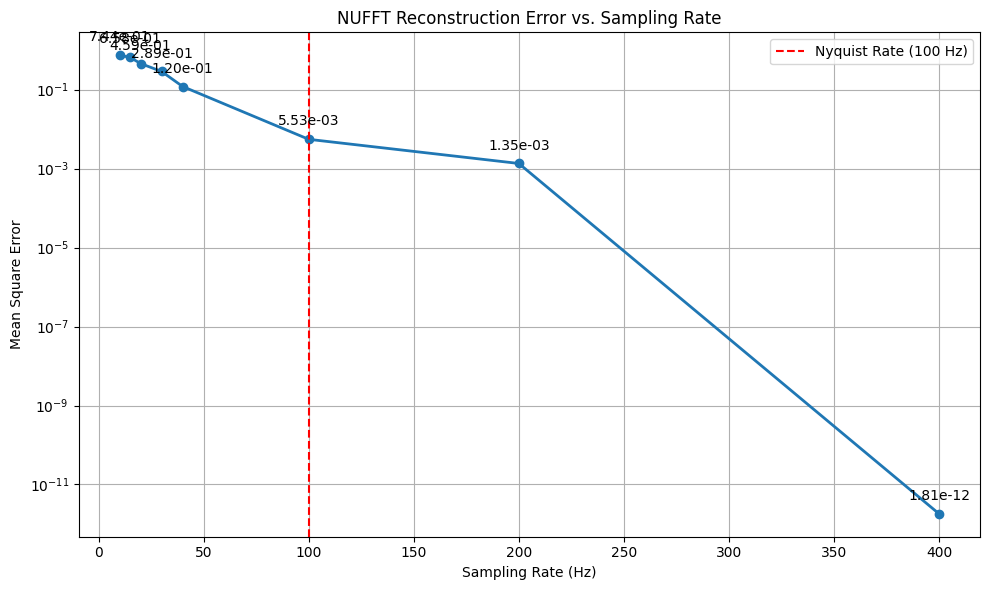


Summary of MSE Results:
-----------------------
N	Sampling Rate (Hz)	MSE
50	10.0		7.441510e-01
75	15.0		6.577008e-01
100	20.0		4.587348e-01
150	30.0		2.889509e-01
200	40.0		1.202296e-01
500	100.0		5.530647e-03
1000	200.0		1.351588e-03
2000	400.0		1.811319e-12


In [ ]:
# Separate function to calculate MSE for different sampling rates
def calculate_nufft_mse(t_ref, y_ref, duration, N_list):
    mse_values = []
    
    for N in N_list:
        # Sample the reference signal at N points
        sample_indices = np.linspace(0, len(t_ref)-1, N, dtype=int)
        t_sample = t_ref[sample_indices]
        y_sample = y_ref[sample_indices]
        
        # Normalize times to [-π, π] for NUFFT
        omega_sample = 2 * np.pi * (t_sample / duration - 0.5)
        
        # Forward NUFFT: nonuniform time → uniform frequency
        nufft_vals = finufft.nufft1d1(omega_sample, y_sample, N, isign=-1)
        
        # Compute inverse NUFFT back to the original reference time points
        omega_ref = 2 * np.pi * (t_ref / duration - 0.5)
        nufft_reconstructed = finufft.nufft1d2(omega_ref, nufft_vals, isign=1) / N
        
        # Calculate reconstruction errors
        mse = np.mean(np.abs(y_ref.real - nufft_reconstructed.real)**2)
        
        # Store MSE for later plotting
        mse_values.append((N, mse))
        
        # Print progress
        print(f"Completed N={N}, MSE={mse:.6f}")
    
    return mse_values

# Function to plot MSE vs sampling rate
def plot_mse_results(mse_values, duration, nyquist_rate=100):
    plt.figure(figsize=(10, 6))
    sample_rates = [N/duration for N, _ in mse_values]  # Convert N to Hz
    mse_list = [mse for _, mse in mse_values]
    
    plt.plot(sample_rates, mse_list, 'o-', linewidth=2)
    plt.axvline(x=nyquist_rate, color='r', linestyle='--', label=f'Nyquist Rate ({nyquist_rate} Hz)')
    plt.title('NUFFT Reconstruction Error vs. Sampling Rate')
    plt.xlabel('Sampling Rate (Hz)')
    plt.ylabel('Mean Square Error')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')  # Log scale to better visualize error reduction
    
    # Add annotations with exact MSE values
    for i, (N, mse) in enumerate(mse_values):
        plt.annotate(f"{mse:.2e}", 
                     (sample_rates[i], mse_list[i]),
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary table
    print("\nSummary of MSE Results:")
    print("-----------------------")
    print("N\tSampling Rate (Hz)\tMSE")
    for N, mse in mse_values:
        print(f"{N}\t{N/duration:.1f}\t\t{mse:.6e}")


# Generate a high-resolution reference signal
duration = 5.0
N_ref = 2000  # High resolution reference
spike_count = 200
t_ref, y_ref, spike_times = generate_spike_train(duration, N_ref, spike_count)
    
# Sample counts to test (including more points around Nyquist rate)
N_list = [50, 75, 100, 150, 200, 500, 1000, 2000]
    
# Calculate MSE
mse_results = calculate_nufft_mse(t_ref, y_ref, duration, N_list)
    
# Plot results
plot_mse_results(mse_results, duration, nyquist_rate=100)

# Ideas for Moving Forward

Apply NUFFT to Real Neuromorphic Olfaction Data

- Use existing datasets from event-based olfactory sensors.

- Preprocess spike-based data to extract nonuniform time series representations.

Benchmark Against FFT-Based Reconstructions

- Analyze reconstruction fidelity when applying FFT to the same datasets.

- Quantify performance differences using metrics like MSE, frequency resolution, and spectral leakage.

Explore Alternate NUFFT Kernels

- Investigate different window or interpolation kernels (e.g., Kaiser–Bessel, Gaussian, Sinc).

- Evaluate their effects on reconstruction accuracy and computational cost.



# Summary

- Neuromorphic signals are nonuniformly sampled, limiting FFT use.

- The NUFFT efficiently enables Fourier analysis on these signals.

- Validated on a simple sine wave and a spike-based neuromorphic signal.

- Early signs: NUFFT can analyze nonuniform data without naive interpolation.

- Cautions: Needs parameter tuning; inverse reconstruction remains tricky.

#

Preliminary results point to NUFFT as a natural tool for neuromorphic analysis — but more validation is needed.